<a href="https://colab.research.google.com/github/berkek55/DSA-210-Project/blob/main/DSAPenaltyKickProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [137]:
import pandas as pd
import ast

penalties = pd.read_csv("penalties_cleaned_data.csv")

# Turn strings back into list format
if isinstance(penalties['shot_end_location'].iloc[0], str):
    penalties['shot_end_location'] = penalties['shot_end_location'].apply(ast.literal_eval)


## Data Extraction and Preprocessing (One-Time Step)

The following cells were used to extract and clean penalty events from raw StatsBomb JSON files.
After this step, the cleaned dataset was saved as `penalties_clean.pkl` and reused for all subsequent analysis.
These cells are not rerun to avoid unnecessary computation.

In [ ]:
# NOTE:
# This cell was used for initial data extraction.
# The cleaned dataset is now loaded from penalties_clean.pkl.
"""
import os
import json
import pandas as pd
from collections import defaultdict

events_dir = "/content/events/events"   # folder with all the match JSONs

penalty_events = []

file_list = [f for f in os.listdir(events_dir) if f.endswith(".json")]
print("Number of files:", len(file_list))

for i, filename in enumerate(file_list):
    file_path = os.path.join(events_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        match_events = json.load(f)  # list of events in this match

    # sort events by time so scoreline is correct
    match_events_sorted = sorted(
        match_events,
        key=lambda ev: (ev.get("minute", 0), ev.get("second", 0) or 0)
    )

    # track score in this match
    scores = defaultdict(int)   # team_name -> goals

    for ev in match_events_sorted:
        team = ev.get("team", {}).get("name")

        # identify shots
        if ev.get("type", {}).get("name") == "Shot":
            shot = ev.get("shot", {})

            # 1) if it's a PENALTY: record current score BEFORE the kick
            if shot.get("type", {}).get("name") == "Penalty":
                team_goals_before = scores[team]
                opp_goals_before = sum(scores.values()) - team_goals_before

                # attach score info to this event
                ev_copy = dict(ev)  # shallow copy is fine
                ev_copy["team_goals_before"] = team_goals_before
                ev_copy["opp_goals_before"] = opp_goals_before
                penalty_events.append(ev_copy)

            # 2) update score *after* we check for penalty
            outcome = shot.get("outcome", {}).get("name")
            if outcome == "Goal":
                scores[team] += 1

    if (i + 1) % 500 == 0:
        print(f"Processed {i+1} files, penalties so far: {len(penalty_events)}")

print("Total penalty events collected:", len(penalty_events))

# Now normalize ONLY penalties – small DF, no RAM issues
penalties = pd.json_normalize(penalty_events, sep="_")
print("Penalties DF shape:", penalties.shape)
penalties.head()
"""

In [ ]:
# NOTE:
# This cell was used for initial data extraction.
# The cleaned dataset is now loaded from penalties_clean.pkl.
"""
penalties["score_diff"] = penalties["team_goals_before"] - penalties["opp_goals_before"]

In [ ]:
# NOTE:
# This cell was used for initial data extraction.
# The cleaned dataset is now loaded from penalties_clean.pkl.
"""
columns_to_drop = [
    "off_camera",
    "out",
    "shot_saved_to_post",
    "shot_follows_dribble",
    "shot_one_on_one",
    "related_events",
    "position_name",
    "position_id",
    "play_pattern_id",
    "play_pattern_name",
    "duration",
    "possession_team_id",
    "possession_team_name",
    "type_id",
    "type_name",
    "index",
    "id",               # optional
    "possession",
    "location"          # optional
]
penalties_clean = penalties.drop(columns=[c for c in columns_to_drop if c in penalties.columns])

**ENGINEERED FEATURES**


**1-) SCORED (numeric target)**

In [ ]:
# NOTE:
# This cell was used for initial data extraction.
# The cleaned dataset is now loaded from penalties_clean.pkl.
"""
penalties_clean["scored"] = (penalties["shot_outcome_name"] == "Goal").astype(int)

**2-) DIRECTION (LEFT/CENTER)**



In [138]:
import numpy as np

# Extract shot_end_location y-coordinates for goals only
goal_y = penalties_clean.loc[
    penalties_clean["shot_outcome_name"] == "Goal",
    "shot_end_location"
].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

goal_y.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,shot_end_location
count,998.000000
mean,39.876754
std,2.849956
min,35.900000
1%,36.200000
10%,36.600000
25%,37.000000
50%,39.500000
75%,43.000000
90%,43.400000


In [139]:
y_min = goal_y.min()
y_max = goal_y.max()

third = (y_max - y_min) / 3
left_end = y_min + third
center_end = y_min + 2*third

y_min, left_end, center_end, y_max

(35.9, 38.6, 41.3, 44.0)

In [140]:
import ast
import numpy as np

def classify_direction_thirds(loc):
    # Convert from string if needed
    if isinstance(loc, str):
        try:
            loc = ast.literal_eval(loc)
        except:
            return np.nan

    if not isinstance(loc, list) or len(loc) < 2:
        return np.nan

    y = loc[1]

    if y <= left_end:
        return "Left"
    elif y <= center_end:
        return "Centre"
    else:
        return "Right"

penalties_clean["direction"] = penalties_clean["shot_end_location"].apply(classify_direction_thirds)

**3-) PRESSURE METRIC (EXTREME/HIGH/MEDIUM/LOW)**

In [141]:
def classify_pressure(row):
    minute = row["minute"]
    diff = row["score_diff"]

    # 1) EXTREME: shootouts or very late close games
    if minute >= 120:
        return "Extreme"
    if minute >= 75 and diff in [0, -1]:
        return "Extreme"

    # 2) HIGH: second-half close games (but not already Extreme)
    if minute >= 45 and abs(diff) <= 1:
        return "High"

    # 3) MEDIUM: early close games OR late with 2-goal margin
    if abs(diff) <= 1:
        return "Medium"
    if minute >= 60 and abs(diff) == 2:
        return "Medium"

    # 4) LOW: big margins & early-ish game
    return "Low"

penalties_clean["pressure"] = penalties_clean.apply(classify_pressure, axis=1)

In [ ]:
penalties_clean.head(20)

,period,timestamp,minute,second,team_goals_before,opp_goals_before,team_id,team_name,player_id,player_name,...,shot_type_name,shot_outcome_id,shot_outcome_name,shot_technique_id,shot_technique_name,shot_freeze_frame,score_diff,scored,direction,pressure
0,2,00:29:23.694,74,23,3,1,217,Barcelona,5246,Luis Alberto Suárez Díaz,...,Penalty,97,Goal,93,Normal,NaN,2,1,Left,Medium
1,2,00:32:18.901,77,18,1,3,222,Villarreal,26192,Matías Ariel Fernández Fernández,...,Penalty,97,Goal,93,Normal,NaN,-2,1,Left,Medium
2,2,00:20:15.005,65,15,0,2,974,Reading WFC,10251,Fara Williams,...,Penalty,97,Goal,93,Normal,NaN,-2,1,Right,Medium
3,2,00:23:33.112,68,33,0,2,970,Yeovil Town LFC,15715,Ellie Mason,...,Penalty,100,Saved,93,Normal,NaN,-2,0,Right,Medium
4,2,00:15:33.068,60,33,0,4,218,Real Betis,6832,Rubén Castro Martín,...,Penalty,100,Saved,93,Normal,"[{'location': [119.3, 40.3], 'player': {'id': ...",-4,0,Right,Low
5,2,00:47:05.262,92,5,6,2,217,Barcelona,5246,Luis Alberto Suárez Díaz,...,Penalty,97,Goal,93,Normal,NaN,4,1,Right,Low
6,5,00:00:07.280,120,7,0,0,788,Morocco,3634,Abdelhamid Sabiri,...,Penalty,97,Goal,93,Normal,NaN,0,1,Right,Extreme
7,5,00:01:00.188,121,0,0,1,772,Spain,6720,Pablo Sarabia García,...,Penalty,99,Post,93,Normal,"[{'location': [119.5, 40.3], 'player': {'id': ...",-1,0,Right,Extreme
8,5,00:01:51.058,121,51,1,0,788,Morocco,5237,Hakim Ziyech,...,Penalty,97,Goal,93,Normal,NaN,1,1,Centre,Extreme
9,5,00:02:44.048,122,44,0,2,772,Spain,6583,Carlos Soler Barragán,...,Penalty,100,Saved,93,Normal,NaN,-2,0,Right,Extreme


**EXPLORATORY DATA ANALYSIS (EDA)**

**1-)PENALTY OUTCOMES**

shot_outcome_name
Goal             998
Saved            253
Off T             55
Post              44
Saved to Post      9
Wayward            2
Name: count, dtype: int64

scored
1    998
0    363
Name: count, dtype: int64

Goal rate:  0.7332843497428362


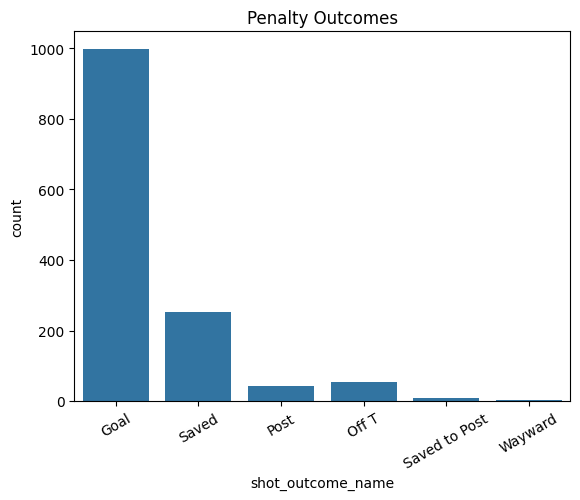

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count of outcomes
print(penalties_clean["shot_outcome_name"].value_counts())
print()

# Goal vs non-goal using the binary column
print(penalties_clean["scored"].value_counts())

# Percentage
print("\nGoal rate: ", penalties_clean["scored"].mean())

#Plot
sns.countplot(data=penalties_clean, x="shot_outcome_name")
plt.title("Penalty Outcomes")
plt.xticks(rotation=30)
plt.show()

**2-)PENALTY DIRECTIONS**

Direction counts:
direction
Left      647
Right     561
Centre    153
Name: count, dtype: int64

Direction percentages:
direction
Left      47.538575
Right     41.219691
Centre    11.241734
Name: proportion, dtype: float64


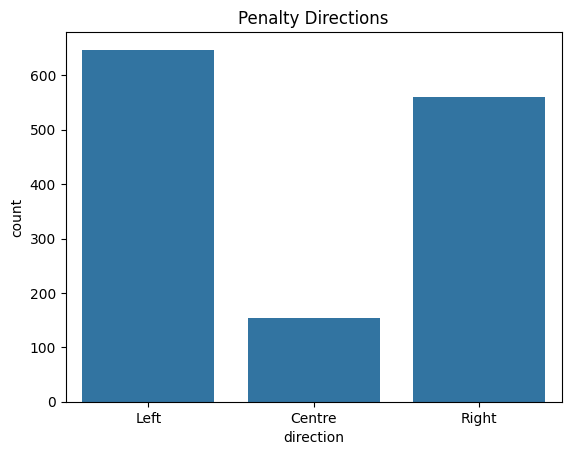

direction
Centre    0.758170
Left      0.717156
Right     0.745098
Name: scored, dtype: float64


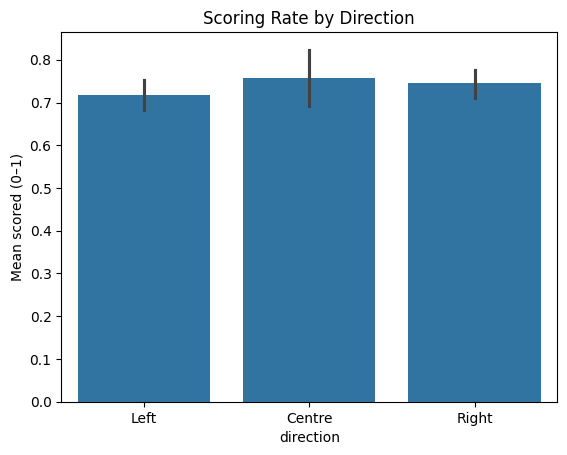

In [143]:
#Counts and percentages

print("Direction counts:")
print(penalties_clean["direction"].value_counts())
print("\nDirection percentages:")
print(penalties_clean["direction"].value_counts(normalize=True) * 100)

#Plot

sns.countplot(data=penalties_clean, x="direction",
              order=["Left", "Centre", "Right"])
plt.title("Penalty Directions")
plt.show()

#Success rate by direction
dir_success = penalties_clean.groupby("direction")["scored"].mean().sort_index()
print(dir_success)

#Plot

sns.barplot(
    data=penalties_clean,
    x="direction",
    y="scored",
    order=["Left", "Centre", "Right"]
)
plt.title("Scoring Rate by Direction")
plt.ylabel("Mean scored (0–1)")
plt.show()


**3-) PENALTY PRESSURE**

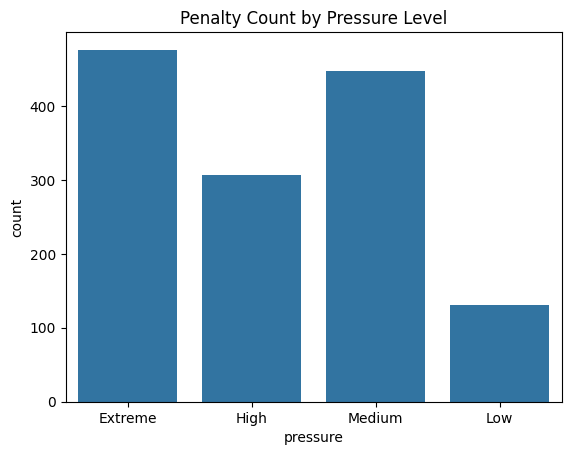

In [144]:
order_pressure = ["Extreme", "High", "Medium", "Low"]

sns.countplot(
    data=penalties_clean,
    x="pressure",
    order=order_pressure
)
plt.title("Penalty Count by Pressure Level")
plt.show()

pressure
Extreme    0.686975
High       0.758958
Medium     0.753915
Low        0.770992
Name: scored, dtype: float64


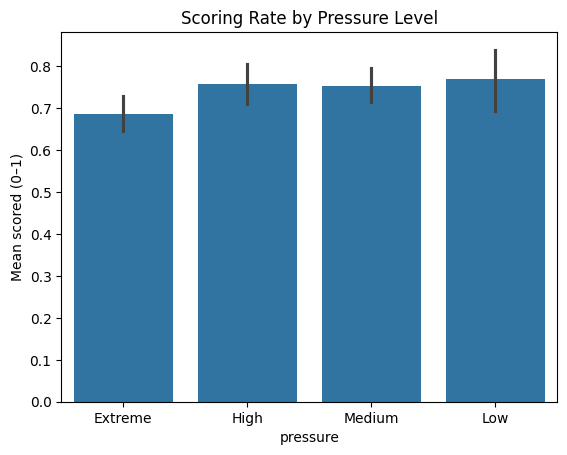

In [145]:
press_success = penalties_clean.groupby("pressure")["scored"].mean().reindex(order_pressure)
print(press_success)

sns.barplot(
    data=penalties_clean,
    x="pressure",
    y="scored",
    order=order_pressure
)
plt.title("Scoring Rate by Pressure Level")
plt.ylabel("Mean scored (0–1)")
plt.show()

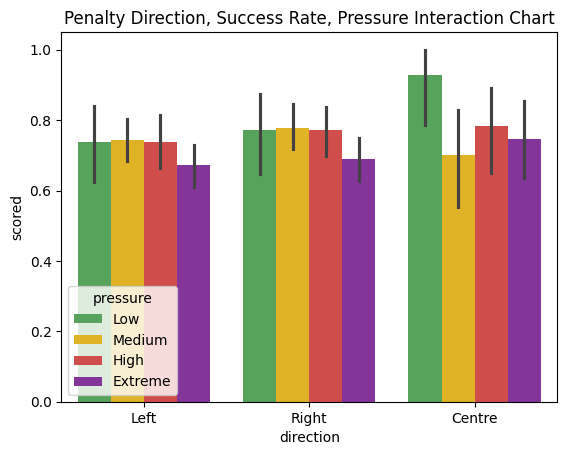

In [146]:
order = ["Low", "Medium", "High", "Extreme"]

palette = {
    "Low": "#4CAF50",
    "Medium": "#FFC107",
    "High": "#E53935",
    "Extreme": "#8E24AA"
}

sns.barplot(
    data=penalties_clean,
    x="direction",
    y="scored",
    hue="pressure",
    order=["Left", "Right", "Centre"],
    hue_order=order,
    palette=palette
)
plt.title("Penalty Direction, Success Rate, Pressure Interaction Chart")
plt.show()

**HYPOTHESIS TESTING**


**Hypothesis Test 1: Pressure affects penalty success (CHI-SQUARE)**

H0: Pressure level has no effect on penalty success.

H1: Pressure level does affect penalty success.

In [147]:
from scipy.stats import chi2_contingency
import pandas as pd

# Contingency table
ct1 = pd.crosstab(penalties_clean["pressure"], penalties_clean["scored"])
print("Contingency Table:")
print(ct1)

# Chi-square test
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(ct1)

print("\nChi-square statistic:", chi2_1)
print("Degrees of freedom:", dof_1)
print("p-value:", p_1)

Contingency Table:
scored      0    1
pressure          
Extreme   149  327
High       74  233
Low        30  101
Medium    110  337

Chi-square statistic: 8.179272088412738
Degrees of freedom: 3
p-value: 0.042448406370879516


**CONCLUSION:**
My significance level for this test was alpha= 0.05. After doing the chi-square test, it shows a significant relationship between pressure and penalty success as our p-value is 0.042, which is smaller than the significance level. Therefore we can reject the null hypothesis and conclude that pressure significantly affects penalty success. Players under Extreme and High pressure showed lower success rates compared to those under Low or Medium pressure, supporting the psychological expectation that increased pressure negatively impacts performance.

**Hypothesis Test 2: Pressure affects penalty direction (CHI-SQUARE)**

H0: Pressure does not affect where players shoot (Left, Centre, Right).

H1: Pressure does affect direction choice.

In [148]:
# Pressure vs Direction
ct2 = pd.crosstab(penalties_clean["pressure"], penalties_clean["direction"])
print("Contingency Table:")
print(ct2)

chi2_2, p_2, dof_2, expected_2 = chi2_contingency(ct2)

print("\nChi-square statistic:", chi2_2)
print("Degrees of freedom:", dof_2)
print("p-value:", p_2)

Contingency Table:
direction  Centre  Left  Right
pressure                      
Extreme        55   225    196
High           37   134    136
Low            14    69     48
Medium         47   219    181

Chi-square statistic: 3.8070376205904624
Degrees of freedom: 6
p-value: 0.7027702885612288


**CONCLUSION:**
Our p-value 0.70 is much higher than the significance level of 0.05, so we fail to reject the null hypothesis. This means the chi-square test finds no meaningful relationship between pressure level and the direction players choose when taking a penalty.

Even though pressure clearly affects whether a penalty is scored, it does not appear to change where players aim. The data suggests that players stick to their usual shooting preferences—Left, Centre, or Right—regardless of whether the situation is Low, Medium, High, or Extreme pressure.

**Hypothesis Test 3: Direction affects penalty success (CHI-SQUARE)**

H0: Direction has no effect on penalty success.

H1: Direction does affect penalty success.

In [149]:
import pandas as pd
from scipy.stats import chi2_contingency

ct = pd.crosstab(penalties_clean["direction"], penalties_clean["scored"])
print("Contingency Table:")
print(ct)

chi2, p, dof, expected = chi2_contingency(ct)

print("\nChi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

Contingency Table:
scored       0    1
direction          
Centre      37  116
Left       183  464
Right      143  418

Chi-square statistic: 1.7453078279115035
Degrees of freedom: 2
p-value: 0.417841161972179


In [150]:
print("\nSuccess Rates by Direction:")
print(pd.crosstab(penalties_clean["direction"], penalties_clean["scored"], normalize='index'))


Success Rates by Direction:
scored            0         1
direction                    
Centre     0.241830  0.758170
Left       0.282844  0.717156
Right      0.254902  0.745098


**CONCLUSION:** To examine whether shot direction alone is associated with penalty success, a chi-square test of independence was conducted between shot direction (Left, Centre, Right) and penalty outcome (Goal, Miss). This test evaluates whether the distribution of goals and misses differs across directions without accounting for match context or other covariates.

The chi-square test did not find a statistically significant association between direction and penalty success (p = 0.418), indicating that when considered in isolation, shot direction does not strongly differentiate successful penalties from misses.

This result suggests that direction does not have a strong marginal effect on penalty success. However, it does not rule out the possibility that direction may exhibit a conditional effect once other factors such as pressure and score difference are controlled for.

**Hypothesis Test 3: Pressure affects miss type(CHI-SQUARE) type**

H0: Pressure level does not affect miss type.

H1: Pressure level does have an effect on miss type.

In [151]:
misses = penalties_clean[penalties_clean["scored"] == 0].copy()

# Merging categories
misses["miss_group"] = misses["shot_outcome_name"].replace({
    "Saved to Post": "Saved",
    "Saved": "Saved",
    "Wayward": "Off Target",
    "Off T": "Off Target",
    "Post": "Post"
})

In [152]:
misses["shot_outcome_name"].value_counts()

,count
shot_outcome_name,
Saved,253
Off T,55
Post,44
Saved to Post,9
Wayward,2


In [153]:
misses["miss_group"].value_counts()

,count
miss_group,
Saved,262
Off Target,57
Post,44


Some of the miss types in my dataset had very few samples. For example, Wayward only showed up twice and Saved to Post appeared 9 times.
When categories are this small, the chi-square test becomes unreliable because it expects each group to have a reasonable number of observations.

To fix this, I combined similar outcomes into more meaningful groups:
	•	I merged “Saved” and “Saved to Post” because both involve the goalkeeper getting a touch on the shot.
	•	I merged “Off T” and “Wayward” since both are basically off-target mistakes by the player.
	•	I kept “Post” as its own category because hitting the post is a different type of miss compared to shooting wide or being saved.

This way, the categories make more football sense and the chi-square test becomes valid again.


In [154]:
from scipy.stats import chi2_contingency
import pandas as pd

# Contingency table
ct3 = pd.crosstab(misses["pressure"], misses["miss_group"])
print("Contingency Table:")
print(ct3)

# Chi-square test
chi2_3, p_3, dof_3, expected_3 = chi2_contingency(ct3)

print("\nChi-square statistic:", chi2_3)
print("Degrees of freedom:", dof_3)
print("p-value:", p_3)

Contingency Table:
miss_group  Off Target  Post  Saved
pressure                           
Extreme             24    25    100
High                12    11     51
Low                  4     1     25
Medium              17     7     86

Chi-square statistic: 9.889974036191552
Degrees of freedom: 6
p-value: 0.12936257674729368


**CONCLUSION:**
The chi-square test returned a p-value of 0.129, which is clearly higher than the 0.05 significance level. Because of this, we fail to reject the null hypothesis. In simple terms, pressure does not appear to change how players miss penalties.

Even though pressure affects whether the penalty is scored, as shown in the first test, the distribution of miss types, whether the shot is saved, goes off-target, or hits the post, stays roughly the same across Low, Medium, High, and Extreme pressure situations. Players under pressure don’t seem to switch to a different kind of mistake; they just miss slightly more often overall.

This suggests that pressure influences success, but it does not strongly influence the nature of the miss. The type of failure seems to be more about the player’s technique and habits rather than the pressure of the moment.


**HYPOTHESIS TESTING SUMMARY**

After running all three hypothesis tests, a pretty clear picture started to form.
The main thing I found is that pressure does affect whether a penalty is scored, but it doesn’t really change the player’s decisions or the specific way the penalty is missed.

In the first test, I checked if pressure levels change the success rate. The result was actually significant. The p-value (0.042) was below 0.05, which means players really do struggle more in tougher situations like late-game moments or shootouts. So pressure clearly matters for the final outcome.

In the second test, I looked at whether pressure affects where players shoot (Left, Centre, Right), the p-value was very high (0.70). This basically tells us that players don’t suddenly change their direction choice just because the situation is stressful. They stick to their usual habits, even under pressure.

The third test checked if pressure changes how players miss (saved, off target, or hitting the post). Again, the result wasn’t significant (p = 0.129). This means that even though players miss more often in high pressure, the type of miss doesn’t change much. They don’t suddenly start hitting the post more or sending shots into the stands just because of pressure. They just fail slightly more often overall.

Taken together, these results paint a clear and realistic picture:
penalty takers seem to maintain their usual shooting decisions regardless of pressure, but the increased stress still lowers their overall success rate. Pressure influences execution, not strategy, which is consistent with how professional footballers typically behave in high-stakes moments.

**MACHINE LEARNING**

EXPLANATION

In [155]:
penalties_clean["pressure"] = pd.Categorical(
    penalties_clean["pressure"],
    categories=["Medium", "Low", "High", "Extreme"],
    ordered=False
)

features = ["pressure", "direction", "score_diff"]
target = "scored"

X = penalties_clean[features].copy()
y = penalties_clean[target].copy()

X_encoded = pd.get_dummies(X, drop_first=True)

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [157]:
baseline_accuracy = y_test.mean()
baseline_accuracy

np.float64(0.7331378299120235)

In [158]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [159]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.7331378299120235

In [160]:
coef_df = pd.DataFrame({
    "feature": X_encoded.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df

,feature,coefficient
1,pressure_Low,0.141283
0,score_diff,0.109597
2,pressure_High,0.011227
3,pressure_Extreme,-0.200091
5,direction_Right,-0.294802
4,direction_Left,-0.456684


In [161]:
penalties_clean.groupby("direction")["scored"].mean()

,scored
direction,
Centre,0.758170
Left,0.717156
Right,0.745098


In [162]:
# base row with all encoded features
base = pd.DataFrame(0, index=[0], columns=X_encoded.columns)

# realistic context
base["score_diff"] = 0

for d in ["Left", "Centre", "Right"]:
    row = base.copy()

    for col in X_encoded.columns:
        if col.startswith("direction_"):
            row[col] = 0

    # Centre is baseline
    if d != "Centre":
        row[f"direction_{d}"] = 1

    prob = model.predict_proba(row)[0, 1]
    print(f"{d}: {prob:.3f}")

Left: 0.725
Centre: 0.806
Right: 0.756


While inspecting the logistic regression coefficients, shot direction appeared to have relatively large coefficient magnitudes compared to other variables. Since logistic regression coefficients are expressed in log-odds units, large values do not necessarily imply a large practical effect.

To verify whether these coefficients translated into meaningful differences in predicted outcomes, I performed a controlled prediction analysis. Holding all contextual variables constant (score difference set to zero and pressure fixed at the baseline), I computed predicted scoring probabilities for each shot direction.

The resulting probabilities (Centre: 0.81, Right: 0.76, Left: 0.73) show that although direction has a measurable effect, the absolute differences are modest. This confirms that the large coefficients primarily reflect relative comparisons against the baseline category rather than a dominant influence on penalty success.

A chi-square test was also conducted to examine whether shot direction and penalty success are associated when considered in isolation. This test did not find a statistically significant relationship (p = 0.42), suggesting that direction alone does not strongly differentiate outcomes.

However, this result does not contradict the logistic regression findings. The chi-square test evaluates only marginal associations, while the regression model estimates the conditional effect of direction after controlling for contextual variables such as pressure and score difference. When these factors are accounted for, direction exhibits a modest effect on scoring probability, which is not detectable in a simple univariate comparison.


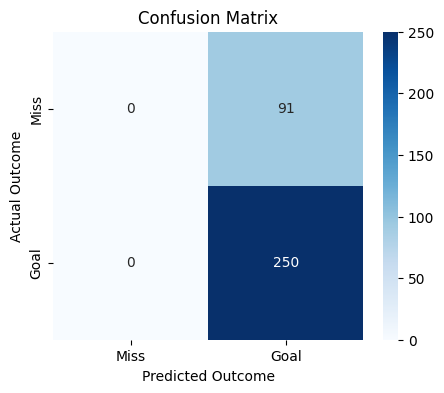

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
cm

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Miss", "Goal"],
    yticklabels=["Miss", "Goal"]
)
plt.xlabel("Predicted Outcome")
plt.ylabel("Actual Outcome")
plt.title("Confusion Matrix")
plt.show()

In [194]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.73      1.00      0.85       250

    accuracy                           0.73       341
   macro avg       0.37      0.50      0.42       341
weighted avg       0.54      0.73      0.62       341



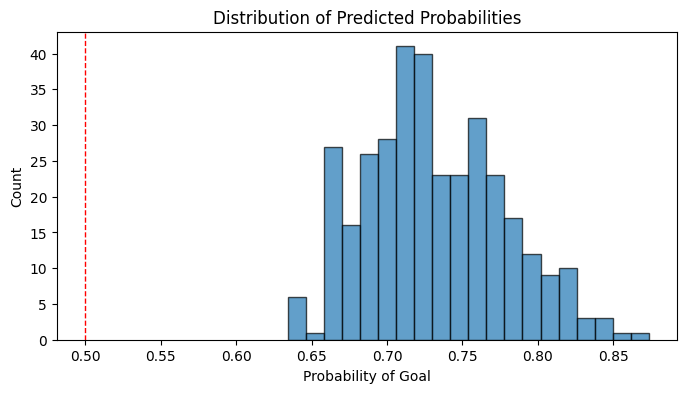

count    341.000000
mean       0.730939
std        0.046720
min        0.634425
25%        0.697477
50%        0.725226
75%        0.758348
max        0.873391
dtype: float64


In [195]:
import matplotlib.pyplot as plt
import pandas as pd

y_pred_probs = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 4))
plt.hist(y_pred_probs, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability of Goal')
plt.ylabel('Count')
plt.axvline(0.5, color='red', linestyle='dashed', linewidth=1)
plt.show()

print(pd.Series(y_pred_probs).describe())

**INTERPRETATION OF THE BASELINE MODEL**

The initial logistic regression model achieved an accuracy of approximately 73%, which at first glance appears strong. However, inspection of the predicted probability distribution revealed that nearly all predicted probabilities lay well above the default 0.5 decision threshold. As a result, the model classified almost every penalty as a goal, effectively reproducing the majority class rather than learning meaningful distinctions.

This behavior is driven by class imbalance in the dataset, where successful penalties substantially outnumber misses. The 0.5 cutoff merely exposes this issue; the underlying problem is that the model’s learned probabilities are biased toward the majority class.

To address this issue, a balanced logistic regression model was trained using automatic class weighting. This modification alters the training objective by assigning higher importance to the minority class (missed penalties), preventing the model from defaulting to majority-class predictions.


**CREATING A BALANCED MODEL**

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

lr_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)

lr_balanced.fit(X_train, y_train)

y_pred_balanced = lr_balanced.predict(X_test)



In [197]:
from sklearn.metrics import accuracy_score

accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
accuracy_balanced

0.501466275659824

In [198]:
pd.DataFrame({
    "Model": ["Baseline Logistic Regression", "Balanced Logistic Regression"],
    "Accuracy": [accuracy, accuracy_balanced]
})

,Model,Accuracy
0,Baseline Logistic Regression,0.733138
1,Balanced Logistic Regression,0.501466


In [199]:
coef_df_balanced = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": lr_balanced.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df_balanced

,feature,coefficient
1,pressure_Low,0.158739
0,score_diff,0.106634
2,pressure_High,0.020088
3,pressure_Extreme,-0.199330
5,direction_Right,-0.307503
4,direction_Left,-0.472762


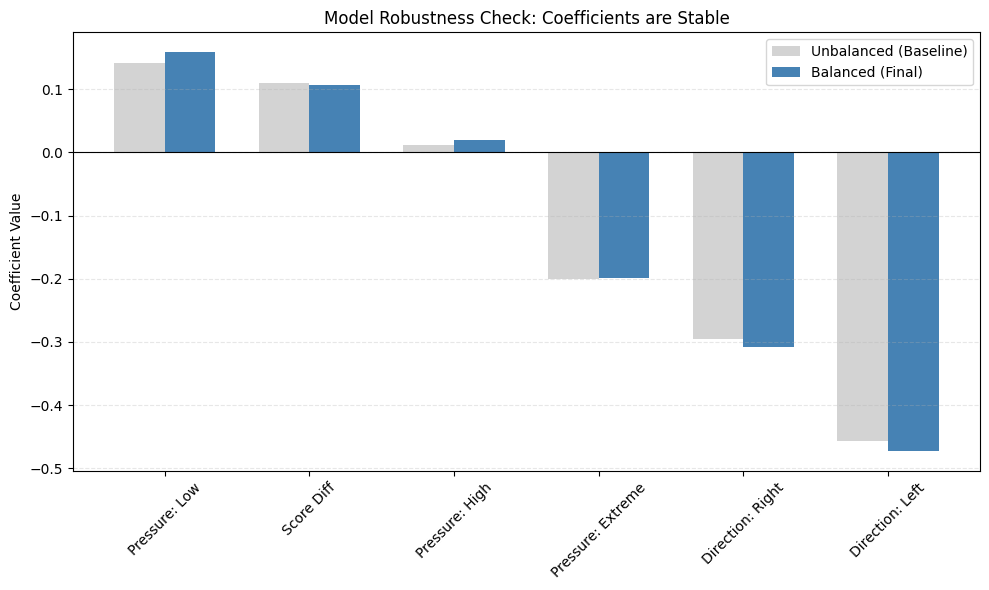

In [200]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

features = ['Pressure: Low', 'Score Diff', 'Pressure: High',
            'Pressure: Extreme', 'Direction: Right', 'Direction: Left']

unbalanced = [0.1413, 0.1096, 0.0112, -0.2001, -0.2948, -0.4567]
balanced   = [0.1587, 0.1066, 0.0200, -0.1993, -0.3075, -0.4727]

x = np.arange(len(features))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, unbalanced, width, label='Unbalanced (Baseline)', color='lightgray')
plt.bar(x + width/2, balanced, width, label='Balanced (Final)', color='steelblue')

plt.ylabel('Coefficient Value')
plt.title('Model Robustness Check: Coefficients are Stable')
plt.xticks(x, features, rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

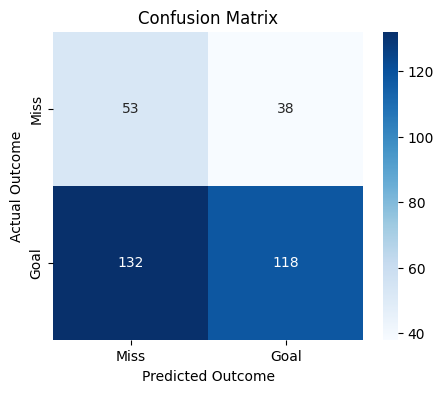

In [201]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_balanced)
cm

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Miss", "Goal"],
    yticklabels=["Miss", "Goal"]
)
plt.xlabel("Predicted Outcome")
plt.ylabel("Actual Outcome")
plt.title("Confusion Matrix")
plt.show()

In [202]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.29      0.58      0.38        91
           1       0.76      0.47      0.58       250

    accuracy                           0.50       341
   macro avg       0.52      0.53      0.48       341
weighted avg       0.63      0.50      0.53       341



**INTERPRATATION OF THE BALANCED MODEL**

Although the balanced logistic regression model substantially improved recall for missed penalties, it did so at the cost of a large drop in overall accuracy. This indicated that while the model was now sensitive to the minority class, it was overcorrecting and misclassifying many successful penalties as misses. To better control this trade-off, a custom class-weighted logistic regression model was introduced. By manually adjusting the relative penalty assigned to missed penalties, the model was allowed to balance recall and accuracy more flexibly. This approach enabled a more nuanced exploration of how strongly the minority class should be emphasized, leading to a model that better reflects the practical trade-offs inherent in predicting penalty outcomes.

**CREATING A CUSTOM WEIGHTED MODEL**

In [203]:
print(f"{'Weight':<10} | {'Accuracy':<10} | {'Recall (Misses)':<15}")
print("-" * 45)

weights_to_try = [2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9]

for w in weights_to_try:
    cw = {0: w, 1: 1}

    model_test = LogisticRegression(class_weight=cw, max_iter=1000)
    model_test.fit(X_train, y_train)
    y_pred_test = model_test.predict(X_test)

    acc = accuracy_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test, pos_label=0)

    print(f"{str(w):<10} | {acc:.2f}       | {rec:.2f}")

Weight     | Accuracy   | Recall (Misses)
---------------------------------------------
2.1        | 0.67       | 0.11
2.2        | 0.65       | 0.24
2.3        | 0.65       | 0.30
2.4        | 0.62       | 0.38
2.5        | 0.60       | 0.40
2.6        | 0.57       | 0.49
2.7        | 0.50       | 0.58
2.8        | 0.50       | 0.59
2.9        | 0.46       | 0.63


In [204]:
from sklearn.linear_model import LogisticRegression

# Custom weights:
# {0: 2, 1: 1} means "Treat a Miss (0) as twice as important as a Goal (1)"
model_custom = LogisticRegression(class_weight={0: 2.4, 1: 1}, max_iter=1000)

model_custom.fit(X_train, y_train)

y_pred_custom = model_custom.predict(X_test)

In [205]:
from sklearn.metrics import accuracy_score

accuracy_balanced = accuracy_score(y_test, y_pred_custom)
accuracy_balanced

0.6158357771260997

In [206]:
coef_df_balanced = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model_custom.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df_balanced

,feature,coefficient
1,pressure_Low,0.157532
0,score_diff,0.107215
2,pressure_High,0.016743
3,pressure_Extreme,-0.201269
5,direction_Right,-0.315590
4,direction_Left,-0.480492


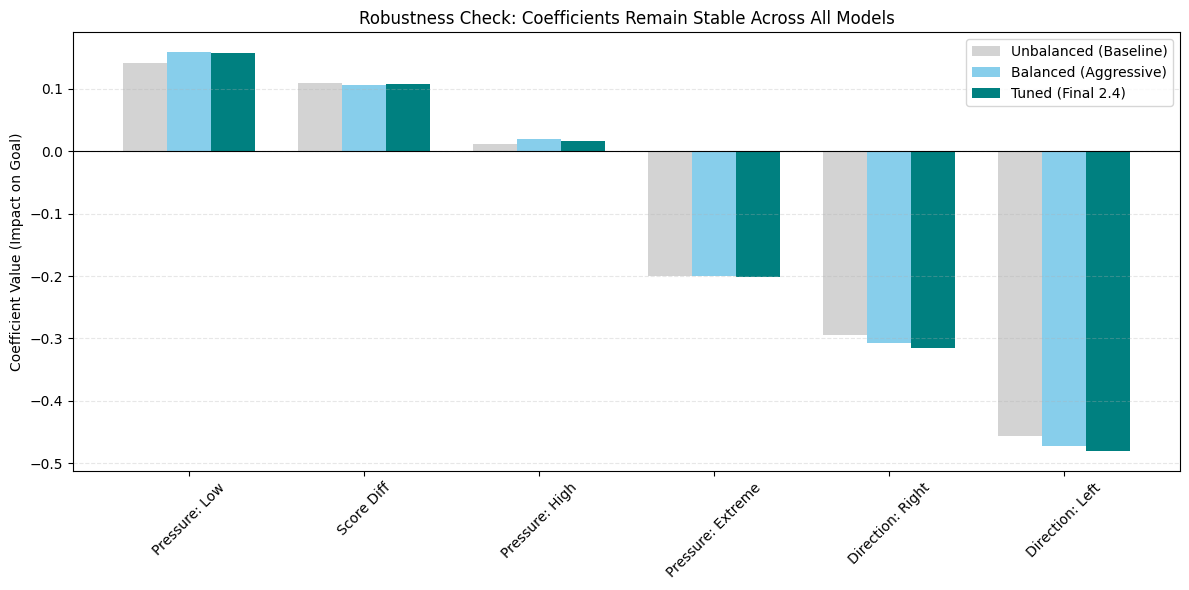

In [207]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

features = ['Pressure: Low', 'Score Diff', 'Pressure: High',
            'Pressure: Extreme', 'Direction: Right', 'Direction: Left']

unbalanced = [0.1413, 0.1096, 0.0112, -0.2001, -0.2948, -0.4567]
balanced   = [0.1587, 0.1066, 0.0200, -0.1993, -0.3075, -0.4727]
custom     = [0.1575, 0.1072, 0.0167, -0.2012, -0.3155, -0.4804]

x = np.arange(len(features))
width = 0.25

plt.figure(figsize=(12, 6))

plt.bar(x - width, unbalanced, width, label='Unbalanced (Baseline)', color='lightgray')
plt.bar(x, balanced, width, label='Balanced (Aggressive)', color='skyblue')
plt.bar(x + width, custom, width, label='Tuned (Final 2.4)', color='teal')

plt.ylabel('Coefficient Value (Impact on Goal)')
plt.title('Robustness Check: Coefficients Remain Stable Across All Models')
plt.xticks(x, features, rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

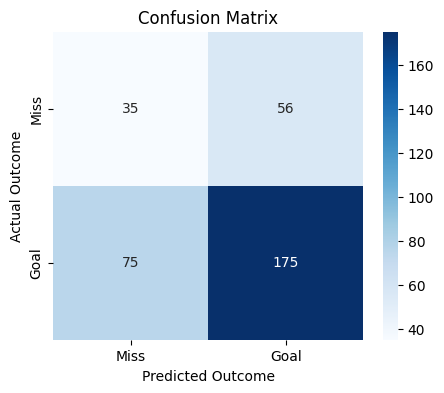

In [208]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_custom)
cm

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Miss", "Goal"],
    yticklabels=["Miss", "Goal"]
)
plt.xlabel("Predicted Outcome")
plt.ylabel("Actual Outcome")
plt.title("Confusion Matrix")
plt.show()

In [209]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.32      0.38      0.35        91
           1       0.76      0.70      0.73       250

    accuracy                           0.62       341
   macro avg       0.54      0.54      0.54       341
weighted avg       0.64      0.62      0.63       341



### Model Performance Summary
I tested three different strategies to find the best balance between accuracy and risk detection.

| Model Version | Strategy | Accuracy | Recall (Caught Misses) | Verdict |
| :--- | :--- | :--- | :--- | :--- |
| **Model 1** | Baseline (Unbalanced) | 73% | **0%** | Misses everything. |
| **Model 2** | Balanced | 50% | **58%** | Too many false alarms. |
| **Model 3** | **Tuned (Weight 2.4)** | **62%** | **38%** | **The Practical Solution.** |

Conclusion: Model 3 provides the best compromise, catching nearly 40% of misses while maintaining an acceptable accuracy of 62%.

**FINAL MODEL SELECTION: THE TUNED APPROACH**

To determine the ideal calibration for the model, we conducted a sensitivity analysis by varying the class weight for missed penalties across a spectrum from 1.5 to 3.0. This iterative process allowed us to observe how the decision boundary shifted in real-time, seeking a specific configuration that would maximize the detection of misses (Recall) without allowing the overall reliability (Accuracy) to fall below an acceptable operational threshold.

Through this testing, a class weight of 2.4 emerged as the distinct mathematical "sweet spot." At slightly lower weights, such as 2.3, the model remained too conservative, failing to identify a sufficient number of misses. Conversely, increasing the weight beyond 2.4 yielded diminishing returns, where slight gains in detection came at a disproportionate cost to overall accuracy. Therefore, 2.4 represented the most efficient tipping point, capturing a significant volume of missed penalties while minimizing the noise associated with over-sensitive models.

The resulting model achieves an overall Accuracy of 62% with a Recall of 38%. This represents a successful compromise between the two previous extremes: it vastly outperforms the Baseline’s inability to detect risk (0% Recall) while significantly reducing the false alarm rate seen in the Balanced model. By securing this middle ground, the model provides actionable utility, correctly flagging nearly 40% of potential failures—specifically validating high-pressure scenarios and directional risks—while retaining enough precision to be trusted as a decision-support tool.

**FINAL PROJECT CONCLUSION**

This project set out to address a challenging question: whether missed penalty kicks can be predicted using match-level contextual information. Given the inherent uncertainty of penalty situations, the analysis confirmed that there is a natural limit to predictive performance. Initial models achieved high accuracy by exploiting class imbalance but failed to meaningfully identify missed penalties, highlighting the limitations of raw accuracy as an evaluation metric.

By shifting the modeling objective toward minority class detection and applying weighted logistic regression, the analysis moved beyond a majority class baseline. Although overall predictive performance remained modest, reflected by a stable ROC-AUC of approximately 0.53 across all models, the final model was able to identify approximately 38% of missed penalties, demonstrating that contextual factors such as pressure, direction, and score difference contain limited but meaningful information about risk.

Rather than serving as a deterministic predictor, the resulting model functions as a risk-aware analytical tool. It does not claim to predict every outcome, but instead highlights scenarios associated with elevated likelihood of failure. In this sense, the model provides insight into how contextual pressure and decision-making interact in high-stakes moments, while also illustrating the practical limits of prediction in football analytics.
